### Predicción de Ventas en las Sucursales de una Cadena de Supermercados

# Trabajo Práctico N°2: Análisis y Curación
Fassi, Carolina Noelia - Fassi, Angel Maximimliano

## Introducción


En este práctico se busca profundizar el conocimiento de las series bajo estudio y realizar tareas de preprocesamiento.

En lo desarrollado en el primer práctico pudimos notar algunas características propias de los datos de series temporales y en particular de las ventas de las sucursales. Algunas de ellas son que se trata de series no estacionarias, o sea que sus distribuciones cambian a través del tiempo pero no parecen presentar raíces unitarias. Además, se aprecian patrones de estacionalidad. Lo antes descripto tiene consecuencias directas en la selección de las metodologías adecuadas para abordar las problemáticas de tratamiento de valores faltantes, detección de outliers y la construcción de modelos predictivos y/o causales.



### Carga del dataset

In [47]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import datetime
import numpy as np
from scipy import stats 

from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

import warnings
warnings.filterwarnings('ignore')

pd.options.display.max_columns = None
sns.set(rc={'figure.figsize':(30, 5)})

Lectura

In [2]:
df_completo = pd.read_excel('dataset_tp2.xlsx')
df_petroc=pd.read_excel('dataset_petro.xlsx')

In [3]:
df_completo.set_index('date',inplace = True)
df_petroc.set_index('date',inplace = True)

# Consignas del trabajo práctico N°2

Se proponen las siguientes actividades motivadoras:

__Transformaciones__

Indagar sobre la utilidad de aplicar transformaciones sobre las series. Por ejemplo: logaritmo natural, diferencias, tasa de crecimiento, estandarización, normalizacion, transformaciones de Box y Cox, etc.

__Tratamiento de outliers y ceros__

- Analizar los posibles cursos de acción a tomar sobre los valores nulos(ceros) de las series.

- Trabajar en la identificación de valores atípicos. Entre otros métodos, se pueden filtrar la tendencia y/o estacionalidad tomando diferencias antes de aplicar los métodos estándar para corte transversal; o el algoritmo Facebook Prophet aplicado a la detección de anomalías[(Ejemplo)](https://www.analyticsvidhya.com/blog/2021/12/anomaly-detection-model-using-facebook-prophet/).  

__Análisis Exploratorio__

Realizar un análisis exploratorio sobre las series tratadas y/o transformadas (reciclando parte del código desarrollado en el TP1).

__Generación de features__

A partir de las series originales generar features, por ejemplo:
- Valores retardados
- Variables dummy: mes del año, día de la semana, etc.

__Opcional__

- Explorar si los features pueden ser útiles para predecir a las series.
- Añadir otros features de la base de datos provista u otras fuentes externas.


## Fecha de entrega

__17/06__ 


## Condiciones de entrega

Realizar un informe en el cual se presenten los resultados y conclusiones del análisis realizado. El mismo debe estar pensado para un público técnico pero que desconoce los aspectos propios del problema a resolver tal como los compañeros de clase. Dicho informe puede ser un notebook, a condición de que en el mismo se efectúe un análisis escrito suficientemente detallado de los resultados. 


#Tratamiento de ceros

Ya cargamos los datos con el tratamiento realizado en el notebook anterior, donde consideramos conveniente imputar con el valor siguiente
 de la serie para cada columna, en lugar de interpolar o usar el valor anterior, ya que se trata de días posteriores a fiestas de Navidad y Año Nuevo, los dias previos a estas festividades se presentaron comunmente en el primer analisis como datos anormales, esta opcion (imputar por el valor siguiente) es la que tendrá un impacto distorsivo menor en los datos.

No consideramos constantes los montos netos, si hicieramos un analisis más estricto donde debieramos respetar por ejemplo la contabilidad financiera, considerariamos como alternativa restar estos valores imputados, prorrateando sobre todos los días del més o la semana en cuestion. 

Mantenemos la alternativa de eliminar todas las tiendas que estan cerradas durante periodos largos de tiempo, con el objetivo de obtener series completamente continuas para todo el dominio.

In [4]:
#Aplicamos el mmismo agrupamiento utilizado en el practico anterior para facilitar el analisis.
dfp_l=df_completo[df_completo.columns[df_completo.mean()<df_completo.mean().quantile(26/100)]]

dfm_l=df_completo[df_completo.columns[df_completo.mean()<df_completo.mean().quantile(74/100)]]
dfm_l=dfm_l[dfm_l.columns[dfm_l.mean()>dfm_l.mean().quantile(25/100)]]

dfg_l=df_completo[df_completo.columns[df_completo.mean()>df_completo.mean().quantile(75/100)]]

df_agg = pd.DataFrame(columns=['Peq', 'Med', 'Gra'])

df_agg['Peq']=dfp_l.mean(axis=1)
df_agg['Med']=dfm_l.mean(axis=1)
df_agg['Gra']=dfg_l.mean(axis=1)


# Transformaciones

## Logaritmica

In [42]:
#Transforación Logaritmo
df_agg['LPeq']=np.log(df_agg['Peq'])
df_agg['LMed']=np.log(df_agg['Med'])
df_agg['LGra']=np.log(df_agg['Gra'])

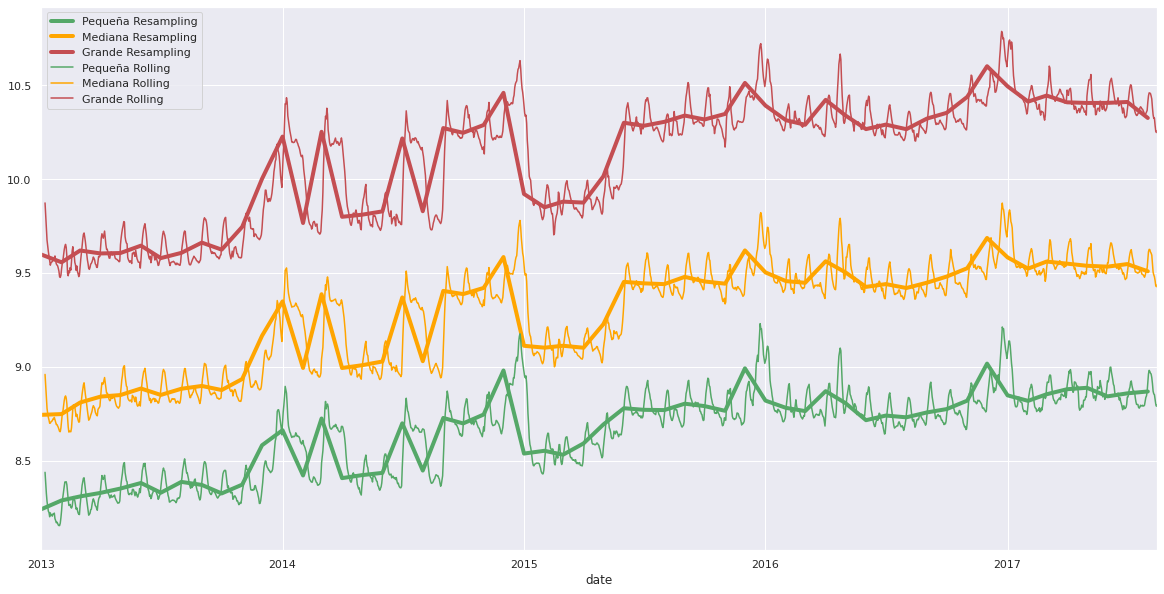

In [44]:
#dfp_lW= dfp_l.mean(axis=1).resample('M').mean()
df_agg['LPeq'].resample('M').mean().plot(color='g', linewidth=4, label="Pequeña Resampling")
df_agg['LMed'].resample('M').mean().plot(color='orange', linewidth=4, label="Mediana Resampling")
df_agg['LGra'].resample('M').mean().plot(color='r', linewidth=4, label="Grande Resampling")

df_agg['LPeq'].rolling(7).mean().plot(color='g', label="Pequeña Rolling")
df_agg['LMed'].rolling(7).mean().plot(color='orange', label="Mediana Rolling")
df_agg['LGra'].rolling(7).mean().plot(color='r', label="Grande Rolling")
plt.legend()
plt.show()

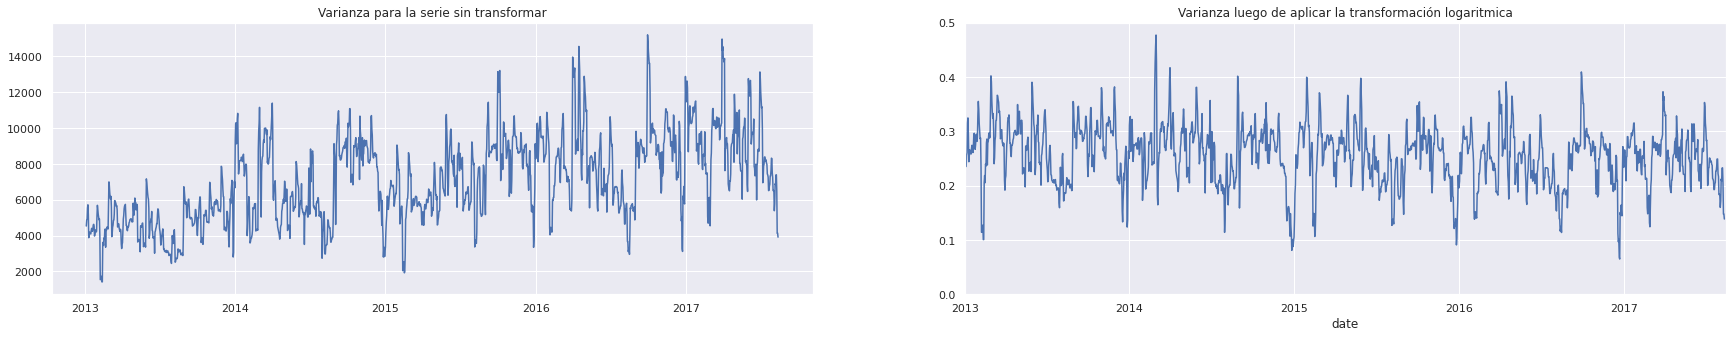

In [7]:
fig, axes= plt.subplots(1,2, sharex=False)
axes[0].plot(df_agg['Gra'].rolling(7, center=True).std()); axes[0].set_title('Varianza para la serie sin transformar')
axes[1].set(ylim=(0,0.5))
df_agg['LGra'].rolling(7, center=True).std().plot()
plt.title('Varianza luego de aplicar la transformación logaritmica')
plt.show()

La transformación logaritmo natural, estabiliza los valores de la varianza, sin embargo esta transformación por si sola no elimina la dependencia del tiempo en los promedios. 

Las tiendas con más volumen de venta son las que presentan mayor variabilidad incluso luego de aplicada la transformación.

## Raiz cuadrada

In [8]:
#Transformación Raiz cuadrada
df_agg['RPeq']=np.sqrt(df_agg['Peq'])
df_agg['RMed']=np.sqrt(df_agg['Med'])
df_agg['RGra']=np.sqrt(df_agg['Gra'])

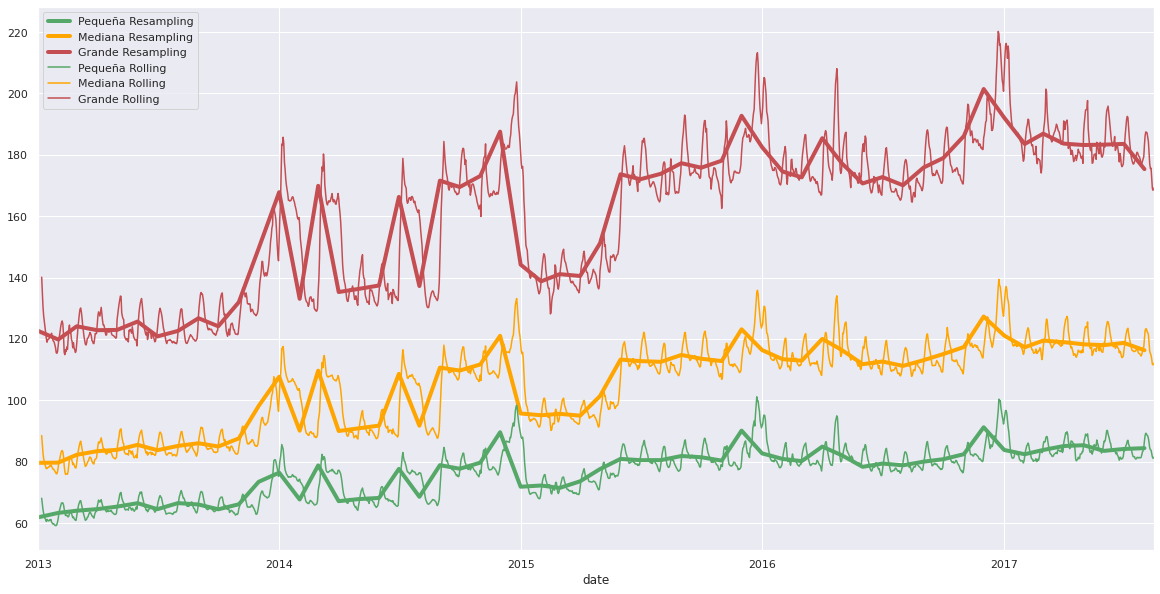

In [46]:
df_agg['RPeq'].resample('M').mean().plot(color='g', linewidth=4, label="Pequeña Resampling")
df_agg['RMed'].resample('M').mean().plot(color='orange', linewidth=4, label="Mediana Resampling")
df_agg['RGra'].resample('M').mean().plot(color='r', linewidth=4, label="Grande Resampling")

df_agg['RPeq'].rolling(7).mean().plot(color='g', label="Pequeña Rolling")
df_agg['RMed'].rolling(7).mean().plot(color='orange', label="Mediana Rolling")
df_agg['RGra'].rolling(7).mean().plot(color='r', label="Grande Rolling")
plt.legend()
plt.show()

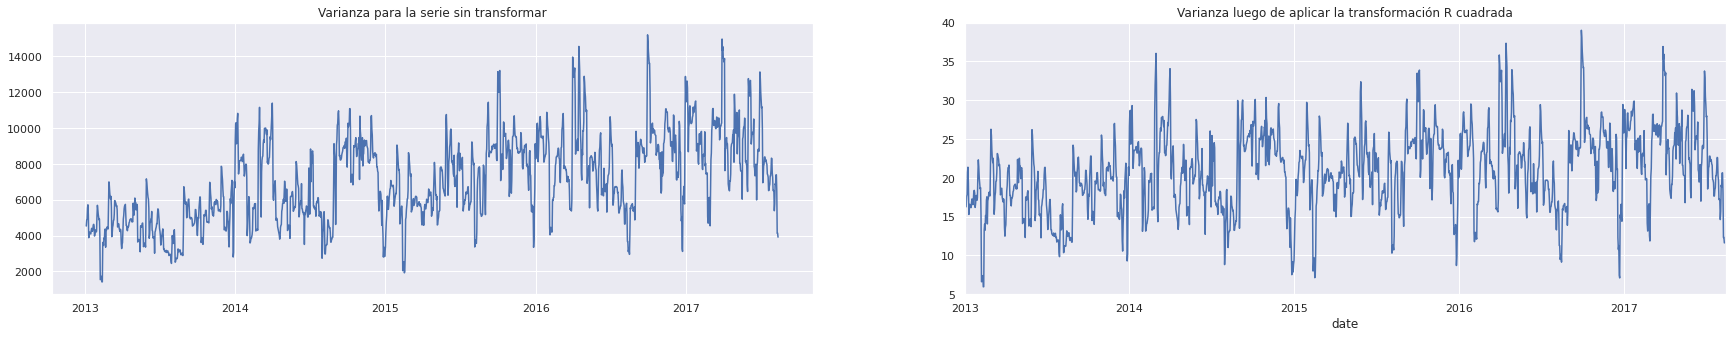

In [10]:
fig, axes= plt.subplots(1,2, sharex=False)
axes[0].plot(df_agg['Gra'].rolling(7, center=True).std()); axes[0].set_title('Varianza para la serie sin transformar')
axes[1].set(ylim=(5,40))
df_agg['RGra'].rolling(7, center=True).std().plot()
plt.title('Varianza luego de aplicar la transformación R cuadrada')
plt.show()

Bajo esta transformación la varianza no se ve a simple vista tan compacta como en el caso de la aplicación de logaritmo, sin embargo también puede ser una buena alternativa si decidimos estabilizarla. 

## Box - Cox

Esta transformación esta definida por la función
$$ Y_i^{\lambda}=\left\{\begin{matrix}
K_1\left (Y_i^{\lambda}-1  \right ), \ \ \         si \lambda\neq 0\\K_2\ln \left (Y_i  \right ),      \ \ \ \ \ \ \  si \lambda= 0 
\end{matrix}\right. $$

Donde $K_2$ es la media geometrica y $K_1$ se dfine como

$K_1=\frac{1}{\lambda K_2^{\lambda-1}}$

Lambda: 0.41673285852417336


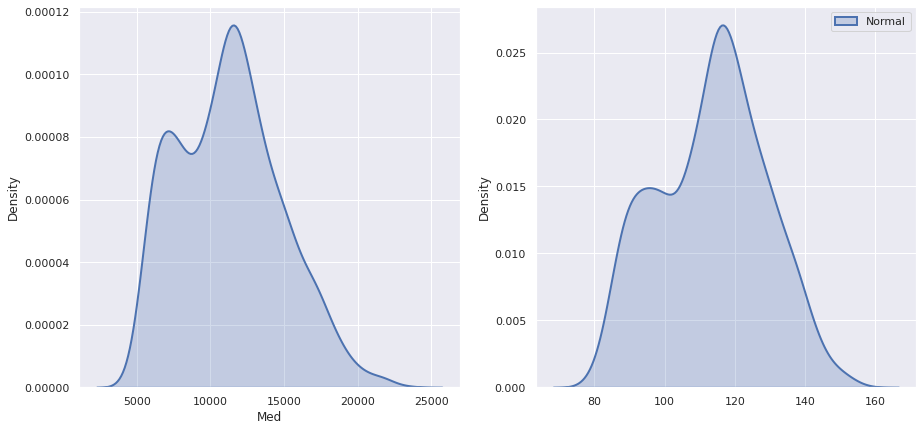

In [48]:
#data = df_agg['Peq']
data = df_agg['Med']
#data = df_agg['Gra']
#data = df_completo['Store 10']
  
fit_data, fit_lambda = stats.boxcox(data) 
  
fig, ax = plt.subplots(1, 2) 
  
sns.distplot(data, hist = False, kde = True, 
            kde_kws = {'shade': True, 'linewidth': 2},  
            label = "Non-Normal", ax = ax[0]) 
  
sns.distplot(fit_data, hist = False, kde = True, 
            kde_kws = {'shade': True, 'linewidth': 2},  
            label = "Normal", ax = ax[1]) 
  
plt.legend(loc = "upper right") 
  
fig.set_figheight(7) 
fig.set_figwidth(15) 
  
print(f"Lambda: {fit_lambda}")

Con este tipo de transformacion, aparecen asimetrias a izquierda en la mayoria de las tiendas, por lo que la misma se traslada a los datos agrupados, ademas la normalizacion generada parece ser bastante deficiente. 
Para tiendas pequeñas y medianas el coeficiente lambda es pequeño, menor a 0,2 por lo que el efecto de la transformación sera bastante similar al obtenido cuando aplicamos la transformación logaritmica. Para las tiendas clasificadas como medianas, sin embargo el coeficiente lambda es practicamente el doble. 


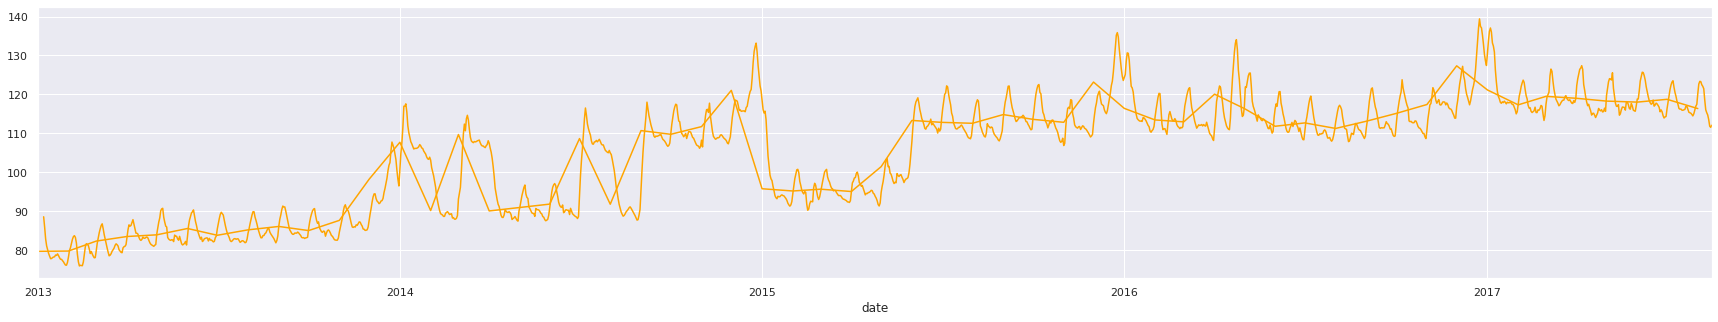

In [12]:
df_agg['BP-Med']=fit_data

#df_agg['BP-Peq'].resample('M').mean().plot(color='g')
df_agg['RMed'].resample('M').mean().plot(color='orange')
#df_agg['BP-Gra'].resample('M').mean().plot(color='r')

#df_agg['BP-Peq'].rolling(7).mean().plot(color='g')
df_agg['RMed'].rolling(7).mean().plot(color='orange')
#df_agg['BP-Gra'].rolling(7).mean().plot(color='r')

plt.show()

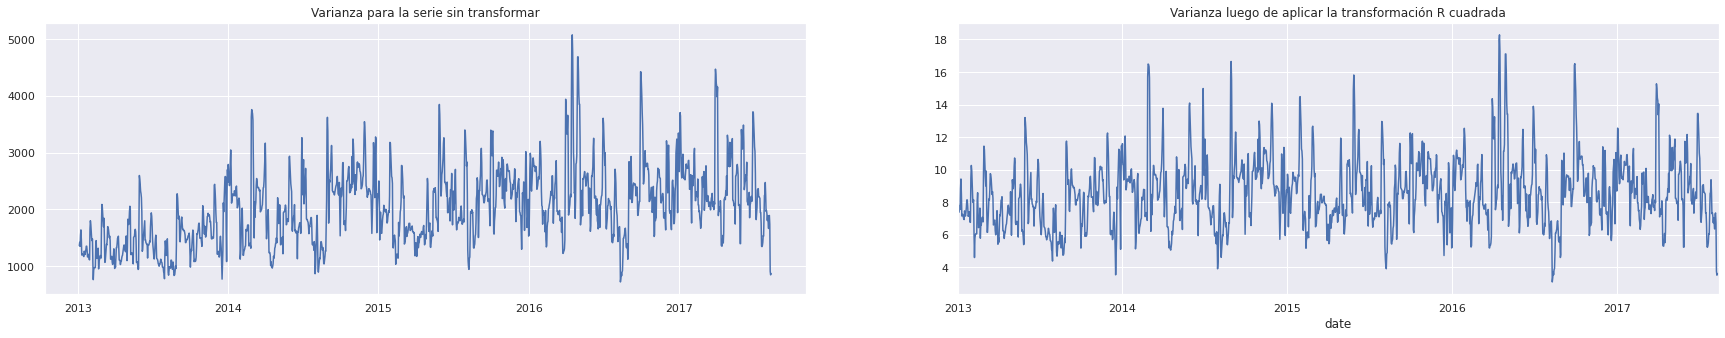

In [13]:
fig, axes= plt.subplots(1,2, sharex=False)
axes[0].plot(df_agg['Med'].rolling(7, center=True).std()); axes[0].set_title('Varianza para la serie sin transformar')
#axes[1].set(ylim=(0.5,4.1))
df_agg['BP-Med'].rolling(7, center=True).std().plot()
plt.title('Varianza luego de aplicar la transformación R cuadrada')
plt.show()

## Diferencias

Las funciones de autocorrelación graficadas en el practico anterior mostraban un decenso lento en los valores, lo que indica que cada valor de la serie esta estrechamente correlacionado con el valor anterior, por lo que si analizamos las differencias entre valores deberiamos obtener un nivel estable, la diferenciación puede ser simple si esta se calcula entre cada valor y el anterior inmediato de la serie, o estacional si se realiza la diferencia entre cada valor y un valor anterior pero no inmediato.  

### **Funciones ACF y PACF en series diferenciadas**

In [14]:
v=df_agg['Med'] #Grupo o serie elegida para analisis

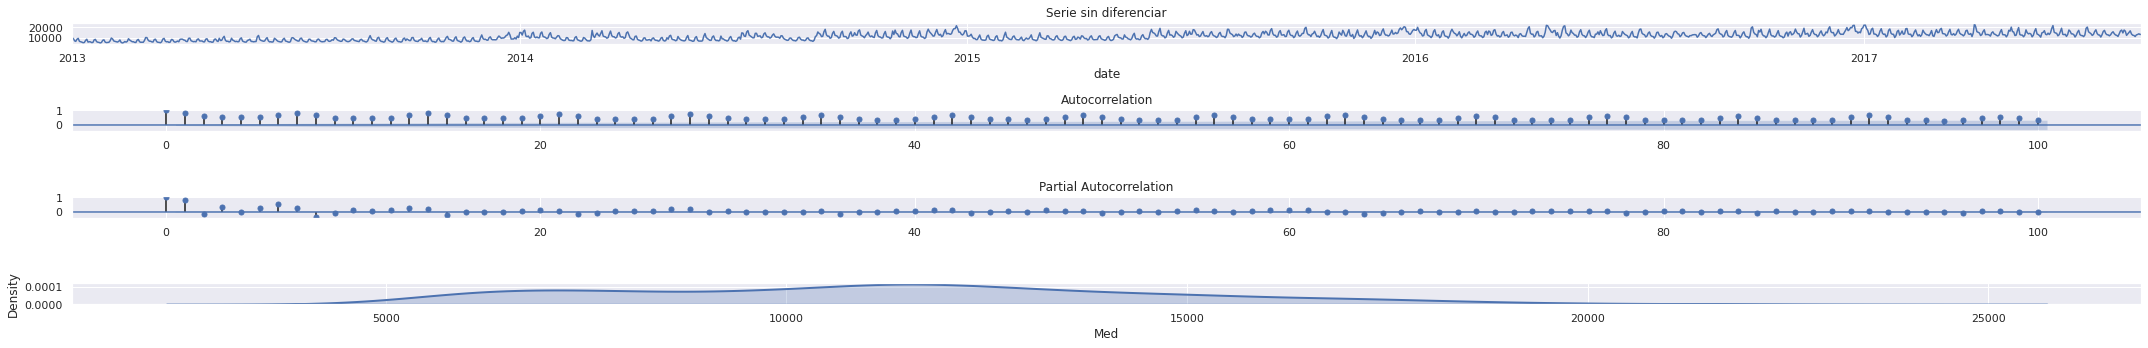

In [49]:
fig, ax = plt.subplots(4)
sns.set(rc={"figure.figsize": (20, 10)})

v.plot(ax=ax[0]); ax[0].set_title('Serie sin diferenciar')
plot_acf(v, lags=100, ax=ax[1])
plot_pacf(v, lags=100, ax=ax[2])
sns.distplot(v, hist = False, kde = True, kde_kws = {'shade': True, 'linewidth': 2}, ax=ax[3])
plt.tight_layout()
plt.show()

La autocorrelación sobre las series sin diferenciar ya habia sido analizada anteriormente, la funcion de autocorrelación parece oscilar, mientras que la autocorrelación parcial recien en el 5 término cae dentro de la zona critica.

#### Diferenciación de primer orden simple

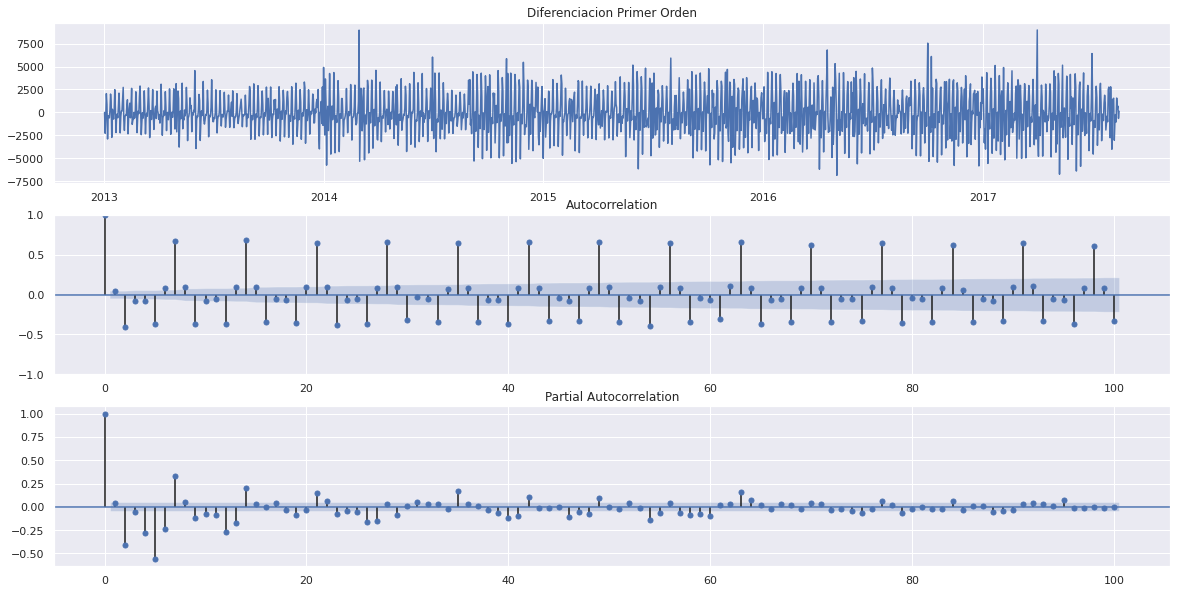

In [16]:
fig, axes= plt.subplots(3)
axes[0].plot(v.diff()); axes[0].set_title('Diferenciacion Primer Orden')
axes[1].set(ylim=(-1,1))
plot_acf(v.diff().dropna(), ax=axes[1], lags=100)
plot_pacf(v.diff().dropna(), ax=axes[2], lags=100)
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


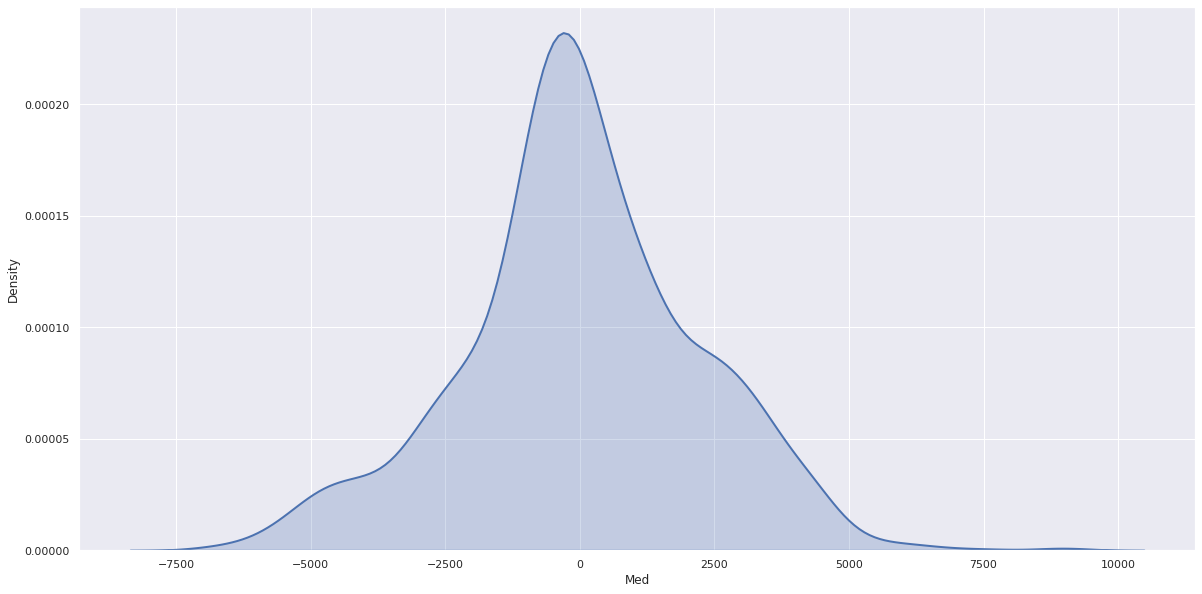

In [17]:
sns.distplot(v.diff(1), hist = False, kde = True, 
            kde_kws = {'shade': True, 'linewidth': 2})
plt.show()

Esta diferenciacion es util para estabilizar la tendencia, pero observando la PACF vemos que los retardos 2,4,5,6,7 son significativos ya que se encuentran muy por encima de la zona critica.

En la autocorrelación simple, si bien la función decrece rapidamente en los primeros terminos y en mayor medida que en el caso de la serie sin diferenciar, el retardo de 7 periodos es múy significativo y no converge o lo hace muy lentamente. 

#### Diferenciación sucesiva simple

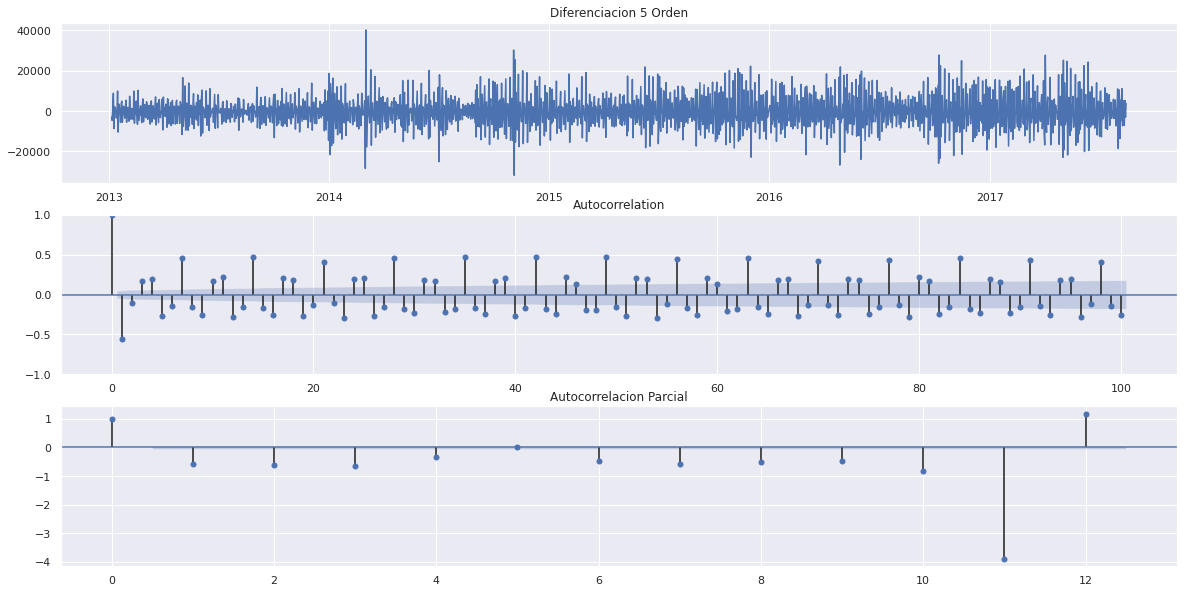

In [50]:
fig, axes= plt.subplots(3,1, sharex=False)
axes[0].plot(v.diff().diff().diff().diff()); axes[0].set_title('Diferenciacion 5 Orden')
axes[1].set(ylim=(-1,1))
plot_acf(v.diff().diff().diff().diff().dropna(), ax=axes[1], lags=100)
plot_pacf(v.diff().diff().diff().diff().dropna(), ax=axes[2], lags=12)
plt.title('Autocorrelacion Parcial')

plt.show()

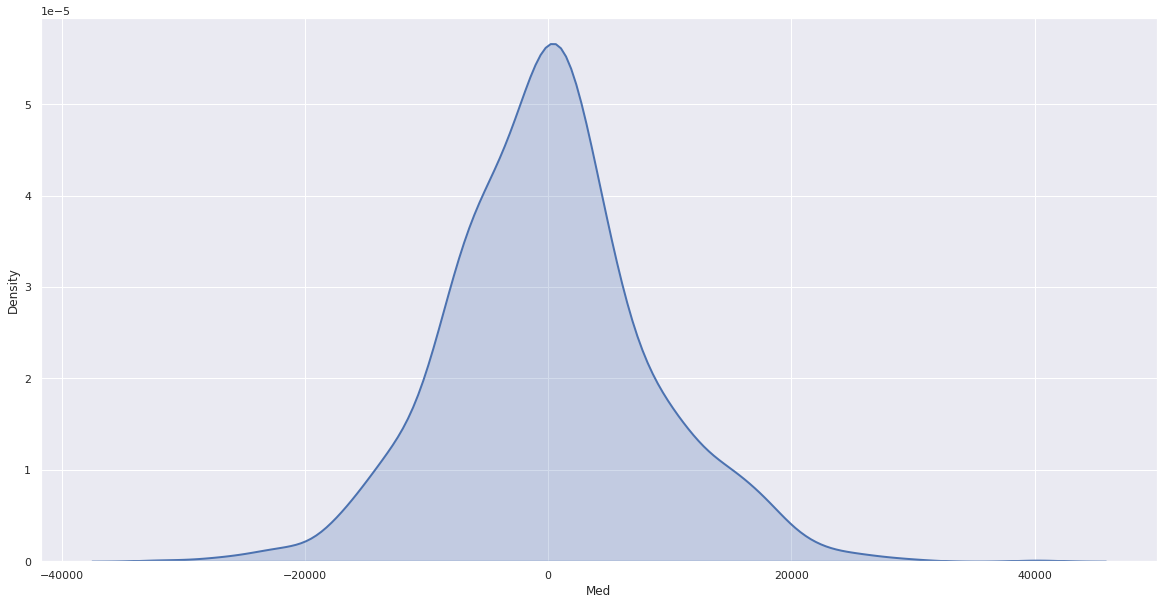

In [51]:
sns.distplot(v.diff().diff().diff().diff(), hist = False, kde = True, 
            kde_kws = {'shade': True, 'linewidth': 2})
plt.show()

A pesar de realizar diferenciaciones de mayor orden la función de autocorrelación no converge significativamente más rapido y la autocorrelación parcial resulta divergente. 

#### Diferenciación de primer orden estacional

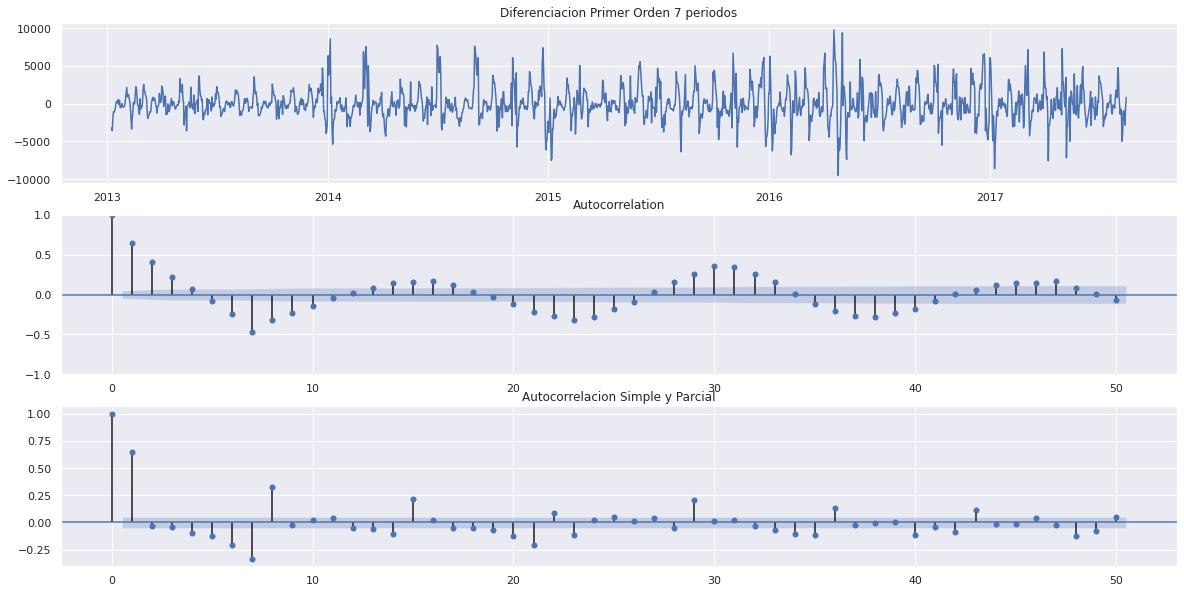

In [20]:
fig, axes= plt.subplots(3,1, sharex=False)
axes[0].plot(v.diff(7)); axes[0].set_title('Diferenciacion Primer Orden 7 periodos')
axes[1].set(ylim=(-1,1))
plot_acf(v.diff(7).dropna(), ax=axes[1], lags=50)
plot_pacf(v.diff(7).dropna(), ax=axes[2], lags=50)
plt.title('Autocorrelacion Simple y Parcial')

plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


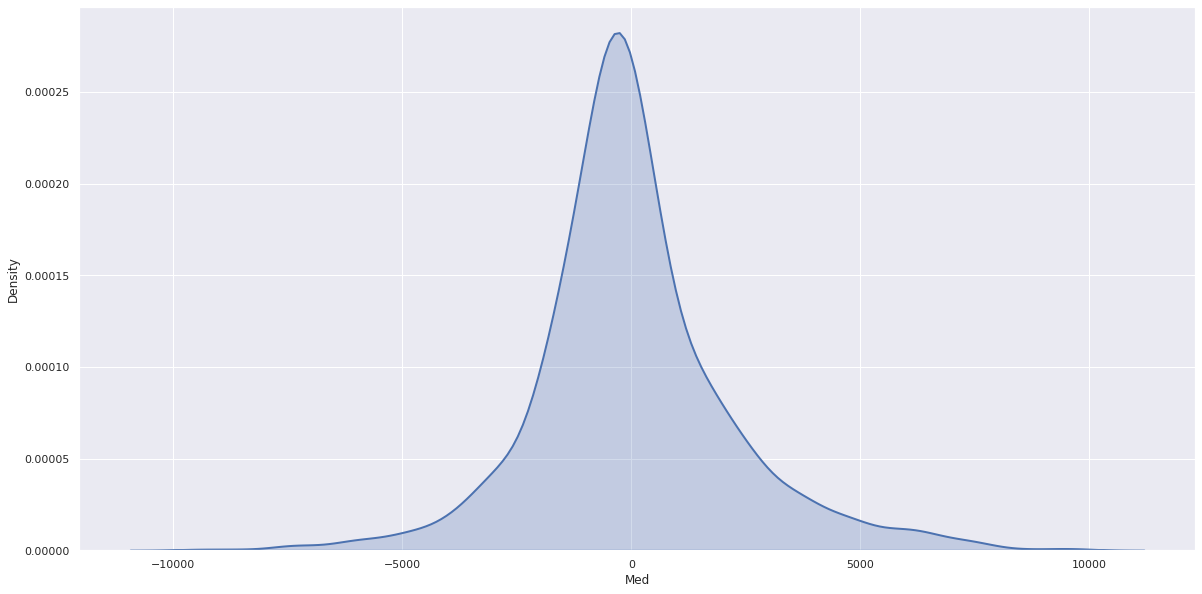

In [21]:
sns.distplot(v.diff(7), hist = False, kde = True, 
            kde_kws = {'shade': True, 'linewidth': 2})
plt.show()

La diferenciación de primer orden pero tomando 7 periodos además de "aplanar" la tendencia creciente de los datos y hacer tender la media a cero, también hace converger las funciones de autocorrelación, aunque el periodo continua siendo significativamente largo los resultados son muy superiores a los demás tipos de diferenciación.
Los histogramas para la variable diferenciada con lag 7, presentan además una distribución de densidad mucho más similar a una distribución normal.

## Estabilización de la media por diferenciación sobre la serie con varianza estable.

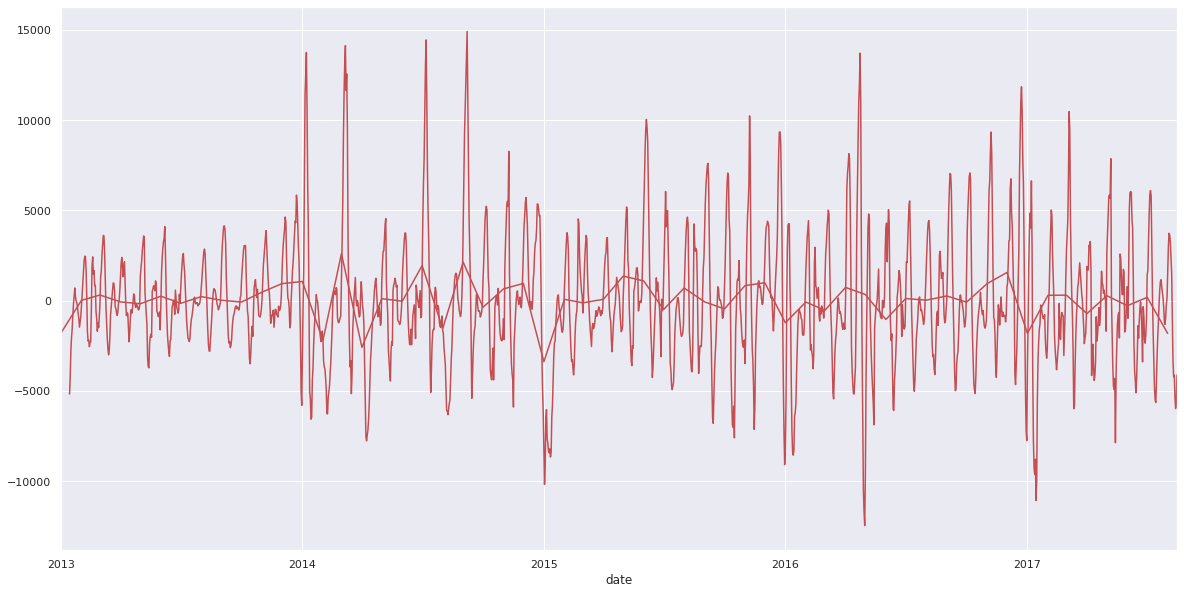

In [22]:
df_agg['D7Peq']=df_agg['Peq'].diff(7)
df_agg['D7Med']=df_agg['Med'].diff(7)
df_agg['D7Gra']=df_agg['Gra'].diff(7)

#df_agg['D7Peq'].resample('M').mean().plot(color='g')
#df_agg['D7Med'].resample('M').mean().plot(color='orange')
df_agg['D7Gra'].resample('M').mean().plot(color='r')

#df_agg['D7Peq'].rolling(7).mean().plot(color='g')
#df_agg['D7Med'].rolling(7).mean().plot(color='orange')
df_agg['D7Gra'].rolling(7).mean().plot(color='r')
plt.show()

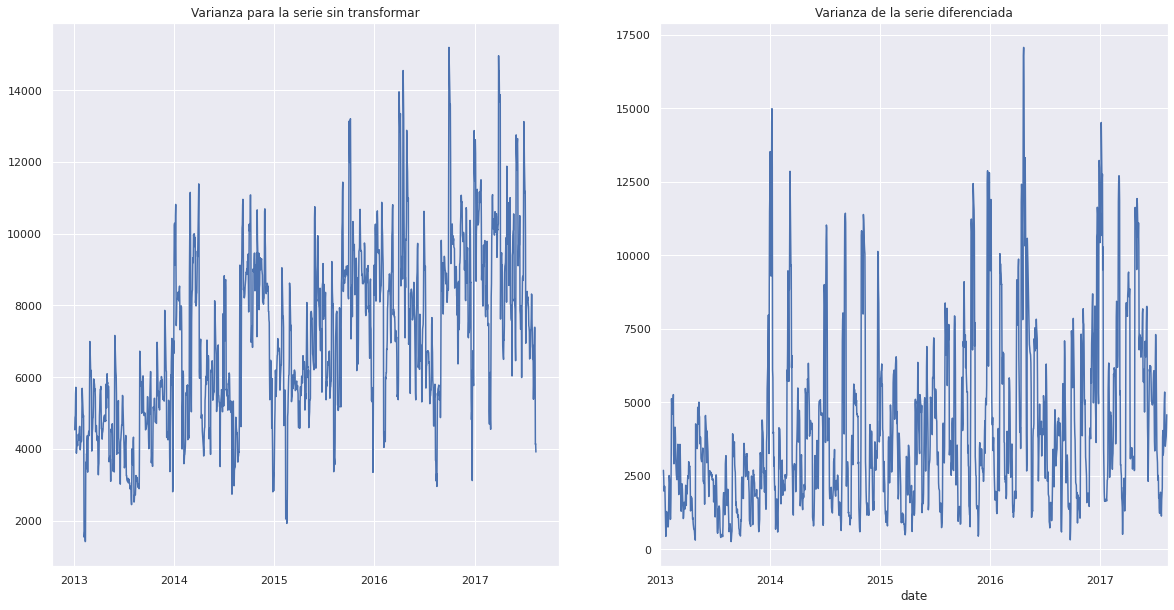

In [23]:
fig, axes= plt.subplots(1,2, sharex=False)
axes[0].plot(df_agg['Gra'].rolling(7, center=True).std()); axes[0].set_title('Varianza para la serie sin transformar')
axes[1]
df_agg['D7Gra'].rolling(7, center=True).std().plot()
plt.title('Varianza de la serie diferenciada')
plt.show()

Vemos que la diferenciación no es suficiente para estabilizar la varianza, que continua teniendo mucha variabilidad, por lo que implementaremos una diferenciación sobre una serie con varianza ya estable. 

In [24]:
#Diferencia estacional sobre la serie transformada mediante log
df_agg['D7_LPeq']=df_agg['LPeq'].diff(7)
df_agg['D7_LMed']=df_agg['LMed'].diff(7)
df_agg['D7_LGra']=df_agg['LGra'].diff(7)

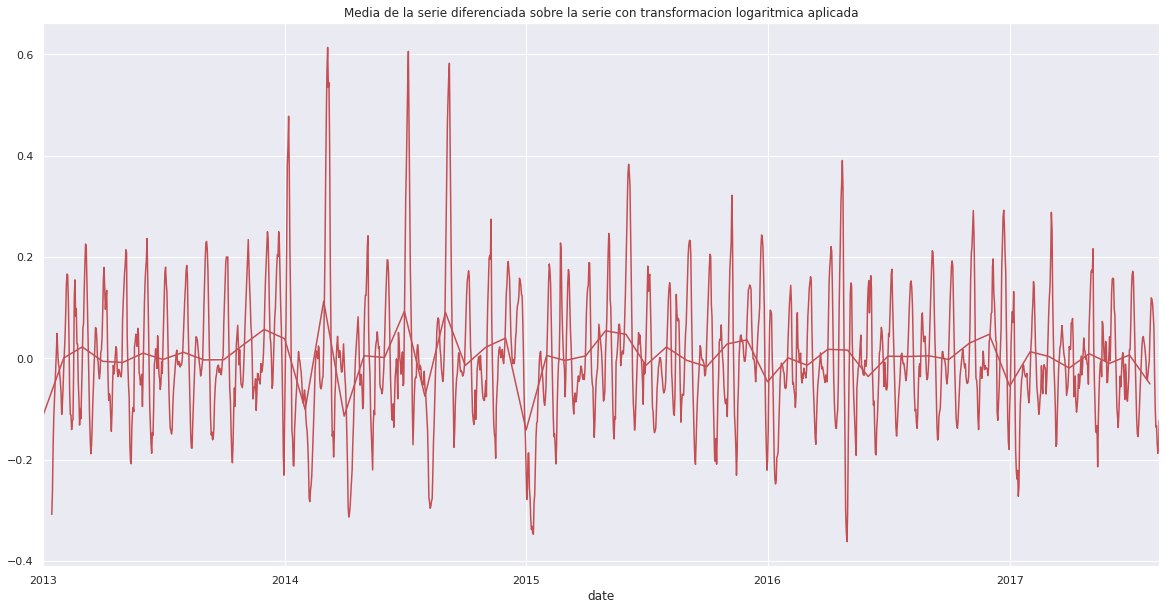

In [25]:
#df_agg['D7Peq'].resample('M').mean().plot(color='g')
#df_agg['D7Med'].resample('M').mean().plot(color='orange')
df_agg['D7_LGra'].resample('M').mean().plot(color='r')

#df_agg['D7Peq'].rolling(7).mean().plot(color='g')
#df_agg['D7Med'].rolling(7).mean().plot(color='orange')
df_agg['D7_LGra'].rolling(7).mean().plot(color='r')

plt.title('Media de la serie diferenciada sobre la serie con transformacion logaritmica aplicada')
plt.show()

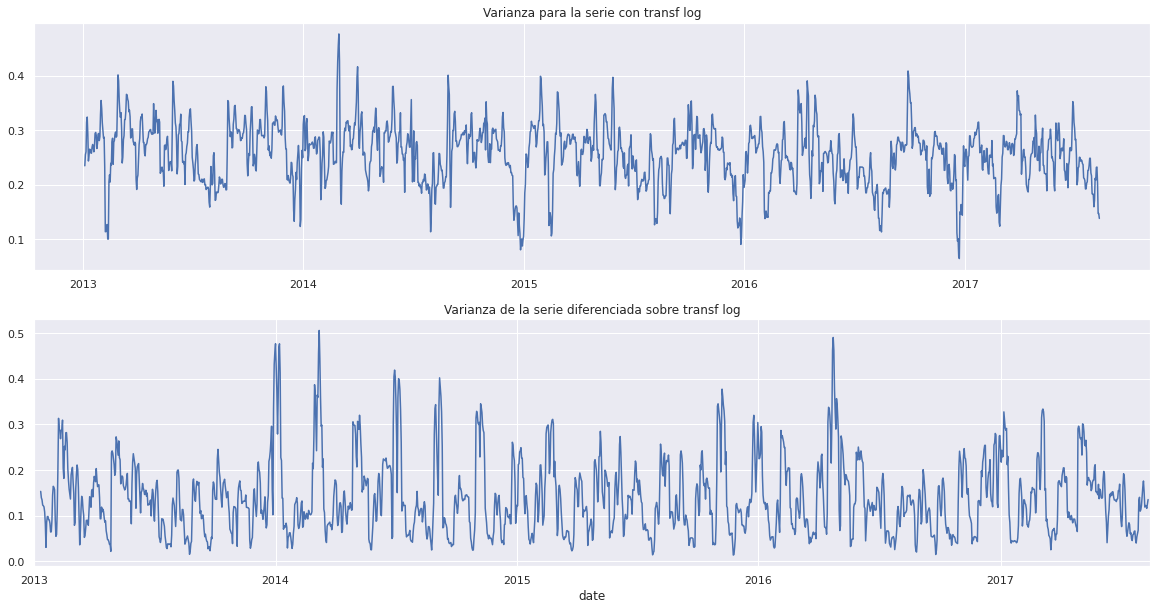

In [26]:
fig, axes= plt.subplots(2)
axes[0].plot(df_agg['LGra'].rolling(7, center=True).std()); axes[0].set_title('Varianza para la serie con transf log')
axes[1]
df_agg['D7_LGra'].rolling(7, center=True).std().plot()
plt.title('Varianza de la serie diferenciada sobre transf log')
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


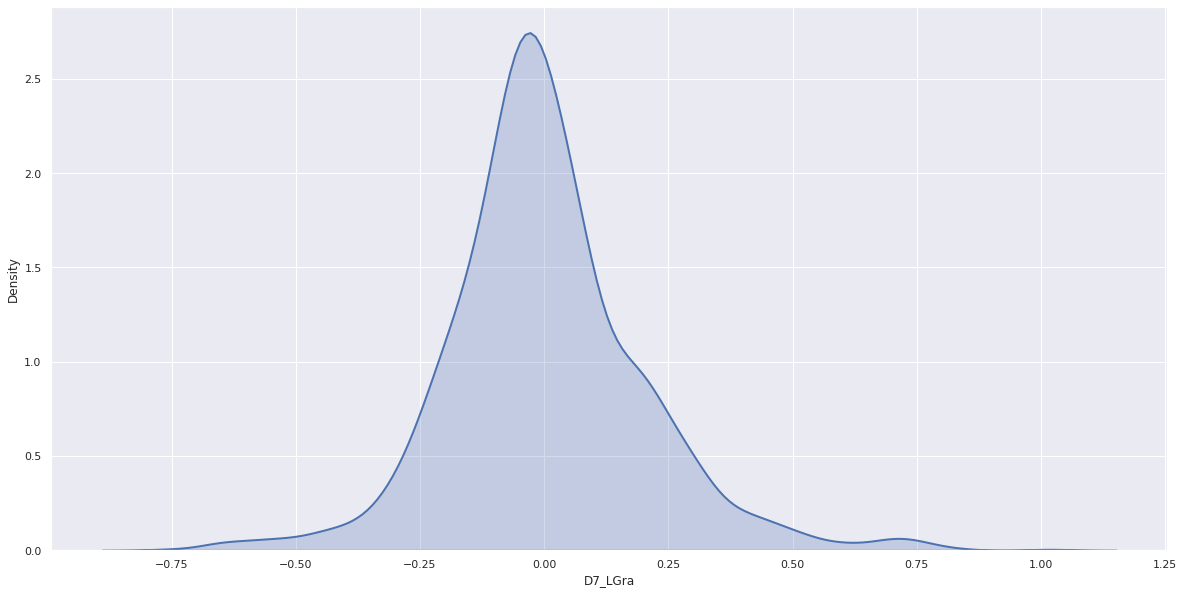

In [27]:
sns.distplot(df_agg['D7_LGra'], hist = False, kde = True, 
            kde_kws = {'shade': True, 'linewidth': 2})
plt.show()

A través de la aplicación de estas dos transformaciones sucesivas, conseguimos una serie con promedios estables y varianzas estables, independientes del tiempo. 

#Facebook Prophet como herramienta para deteccion de anomalias

In [52]:
!pip install pystan==2.19
!pip install fbprophet

from fbprophet import Prophet

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Vamos a utilizar las tiendas medias solo para continuar con el analisis final del TP anterior

In [29]:
#Preparacion del DF
start, end = '2013-01-01', '2016-12-31'
dfm_l=df_completo.loc[start:end][df_completo.columns[df_completo.mean()<df_completo.mean().quantile(74/100)]]
dfm_l=dfm_l.loc[start:end][dfm_l.columns[dfm_l.mean()>dfm_l.mean().quantile(25/100)]]

dfm_l['suma']=dfm_l.sum(axis=1)
dfm_fp = dfm_l.reset_index()[['date', 'suma']].rename({'date':'ds', 'suma':'y'}, axis='columns')

In [53]:
#Train
m = Prophet(interval_width=0.95)
model = m.fit(dfm_fp)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


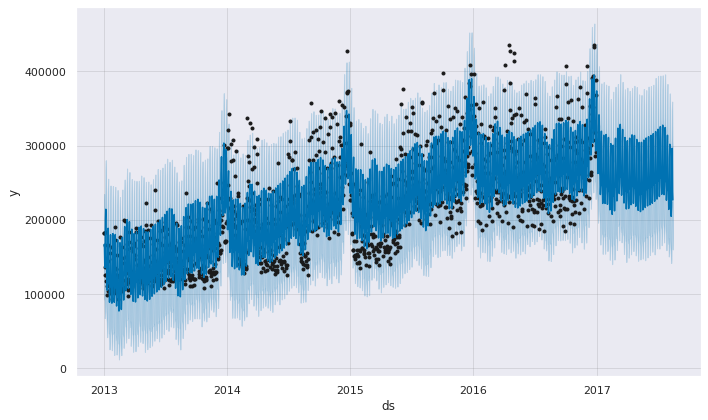

In [31]:
#Test
future = m.make_future_dataframe(periods=227,freq='D')
forecast = m.predict(future)
plot1 = m.plot(forecast)

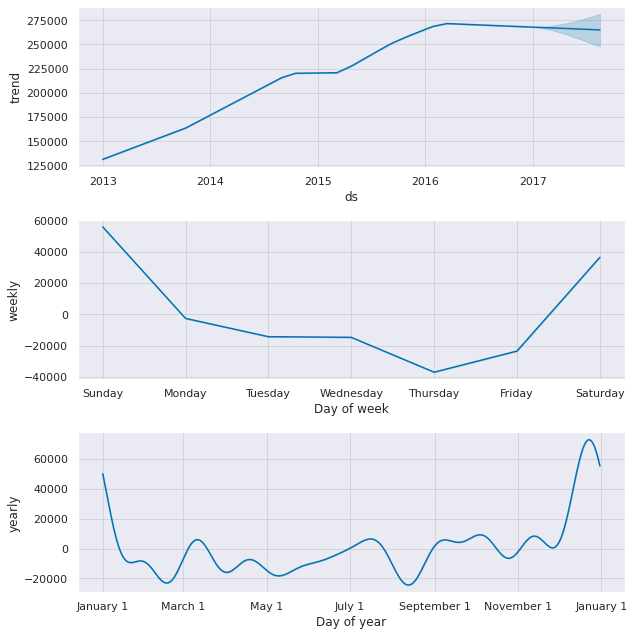

In [32]:
plt2 = m.plot_components(forecast)

Podemos ver que el análisis desagregado que presenta el modelo es coincidente con el análisis exploratorio realizado en el práctico anterior, la estacionalidad semanal es exactamente la misma, con máximos presentes en los sabados y domingos y minimos en los días jueves. Mientras que la estacionalidad mensual también coincide con las conclusiones obtenidas anteriormente, con máximos muy marcados en el més de diciembre.

In [33]:
#forecast


In [34]:
#Preparacion del DFt

dfm_l=df_completo[df_completo.columns[df_completo.mean()<df_completo.mean().quantile(74/100)]]
dfm_l=dfm_l[dfm_l.columns[dfm_l.mean()>dfm_l.mean().quantile(25/100)]]

dfm_l['suma']=dfm_l.sum(axis=1)
#dfm_fp = dfm_l.reset_index()[['date', 'suma']].rename({'date':'ds', 'suma':'y'}, axis='columns')

In [35]:
forecast.set_index('ds',inplace = True)
test=pd.concat((forecast,dfm_l.suma), axis=1)
#test

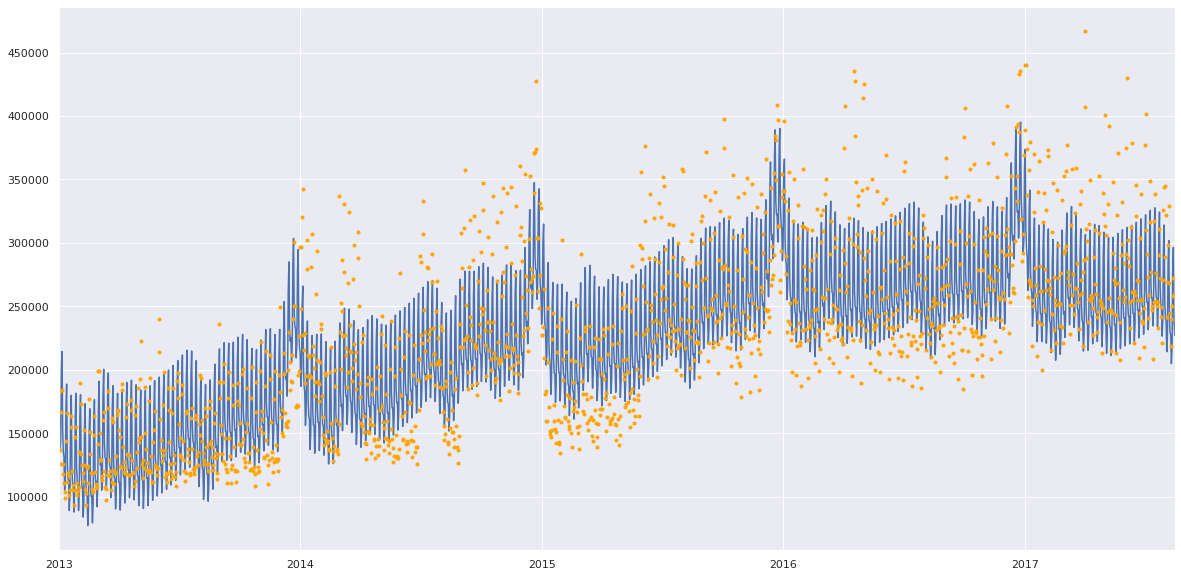

In [36]:
test.yhat.plot()
test.suma.plot(marker='.', linestyle='None', color='orange')
plt.show()

In [37]:
#Error
test['error']=test['suma']-test['yhat']
test['incert']=test['yhat_upper']-test['yhat_lower'] #definimos un intervalo de "incertidumbre" con los valores arrojados por este algoritmo.


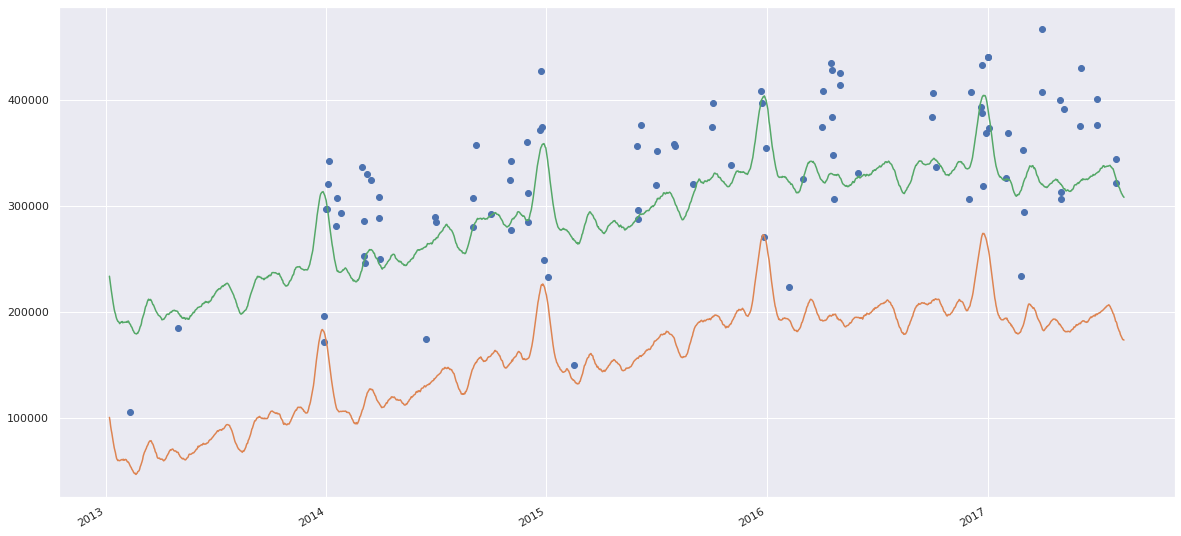

In [54]:
test[test['error'].abs() > 0.5*test['incert']].suma.plot(marker='o', linestyle='None')
test['yhat_lower'].rolling(7).mean().plot()
test['yhat_upper'].rolling(7).mean().plot()
plt.show()

In [39]:
test[test['error'].abs() > 0.4*test['incert']]

,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat,suma,error,incert
2013-02-10,135662.875354,109292.753730,240169.128341,135662.875354,135662.875354,37488.341164,37488.341164,37488.341164,55728.818448,55728.818448,55728.818448,-18240.477284,-18240.477284,-18240.477284,0.0,0.0,0.0,173151.216517,105800.057011,-67351.159506,130876.374611
2013-05-01,144848.679561,50188.143580,178424.667660,144848.679561,144848.679561,-29262.477538,-29262.477538,-29262.477538,-14715.322053,-14715.322053,-14715.322053,-14547.155485,-14547.155485,-14547.155485,0.0,0.0,0.0,115586.202023,185291.895910,69705.693887,128236.524081
2013-12-14,173952.895956,196428.303010,327023.989328,173952.895956,173952.895956,87379.691661,87379.691661,87379.691661,36302.068628,36302.068628,36302.068628,51077.623033,51077.623033,51077.623033,0.0,0.0,0.0,261332.587617,199471.170018,-61861.417599,130595.686317
2013-12-15,174113.083621,218621.808560,347801.429432,174113.083621,174113.083621,110863.288848,110863.288848,110863.288848,55728.818448,55728.818448,55728.818448,55134.470400,55134.470400,55134.470400,0.0,0.0,0.0,284976.372469,229390.662940,-55585.709530,129179.620872
2013-12-22,175234.397277,239350.676223,370696.633042,175234.397277,175234.397277,128249.667792,128249.667792,128249.667792,55728.818448,55728.818448,55728.818448,72520.849344,72520.849344,72520.849344,0.0,0.0,0.0,303484.065069,250480.355979,-53003.709090,131345.956819
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-06-11,265881.881568,243897.208570,380163.619970,255325.921107,275605.632872,47898.837882,47898.837882,47898.837882,55728.818448,55728.818448,55728.818448,-7829.980565,-7829.980565,-7829.980565,0.0,0.0,0.0,313780.719450,379084.537855,65303.818405,136266.411400
2017-07-01,265628.757094,232822.169815,368988.595629,252794.661727,277392.517237,36526.514617,36526.514617,36526.514617,36302.068628,36302.068628,36302.068628,224.445990,224.445990,224.445990,0.0,0.0,0.0,302155.271712,376792.299987,74637.028275,136166.425814
2017-07-02,265616.100871,256465.980479,394037.435193,252690.656120,277478.135671,56451.184295,56451.184295,56451.184295,55728.818448,55728.818448,55728.818448,722.365847,722.365847,722.365847,0.0,0.0,0.0,322067.285166,401356.225050,79288.939884,137571.454713
2017-08-01,265236.414161,168060.505120,305742.272727,249752.930250,280247.649661,-24887.867282,-24887.867282,-24887.867282,-14293.502326,-14293.502326,-14293.502326,-10594.364956,-10594.364956,-10594.364956,0.0,0.0,0.0,240348.546879,344443.356163,104094.809284,137681.767608


In [56]:
HE=pd.read_csv('holidays_events.csv')

HE.date = pd.to_datetime(HE.date)
HE.set_index('date',inplace = True)

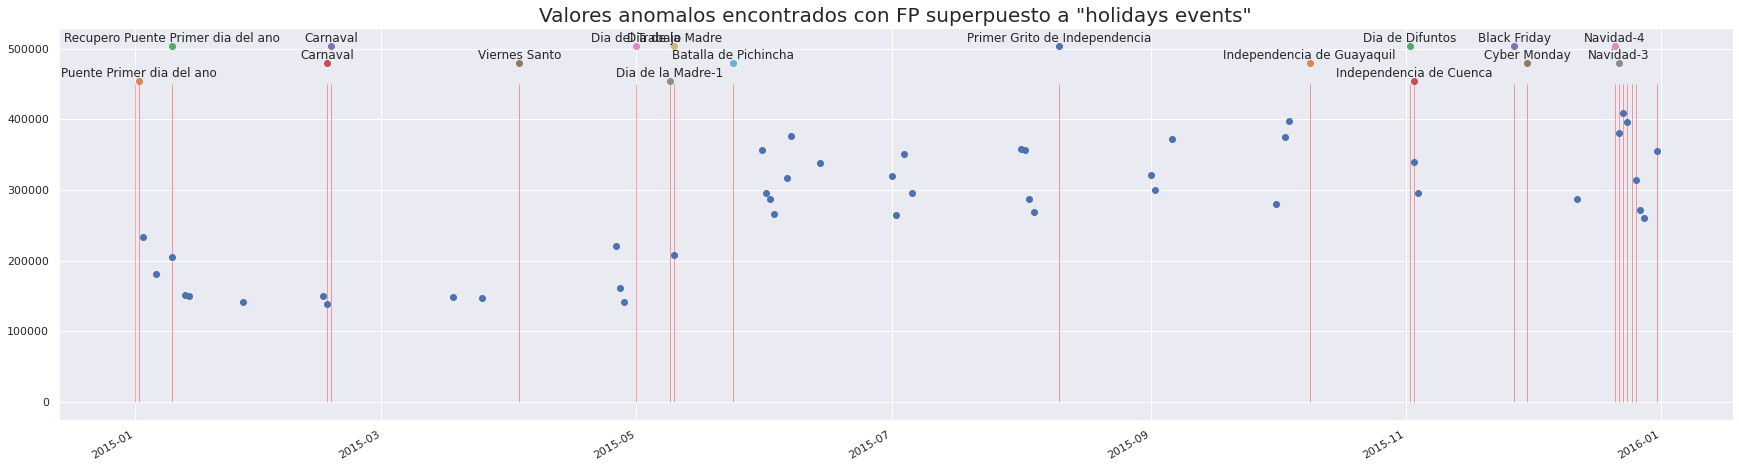

In [57]:
# Df 
temp_df1 = HE[(HE['locale'] == 'National') & (HE['transferred'] == False)]
temp_df2 = HE[(HE['locale'] == 'National') & (HE['transferred'] == False)].reset_index()
temp_df3=test[test['error'].abs() > 0.40*test['incert']].suma

# Plots
start, end = '2015-01-01', '2015-12-31'
fig,ax=plt.subplots(figsize=(30,8))
temp_df3[start:end].plot(marker='o', linestyle='None')
plt.vlines(x=temp_df1[start:end].index, color='red', ymin=0,ymax=450000, lw=0.5, alpha=0.7)
plt.title('Valores anomalos encontrados con FP superpuesto a "holidays events"', fontsize=20)

#i_petroc=df_petroc[start:end].rolling(2,center=True).mean()
#plt.plot(i_petroc*100000, label="Precio del Petroleo", linewidth=5, color='black')

for n in range(72, 89, 1):
    if n % 2 == 0:
        delta = -25000
        if n % 3 == 0:
          delta = -50000
    else:
        delta=0
    plt.annotate(temp_df2.loc[n,'description'], (temp_df2.loc[n,'date'], 510000+delta), ha='center')
    plt.plot(temp_df2.loc[n,'date'], 504000+delta, 'o')
plt.show()

# Conclusiones finales:
## Tratamiento de ceros:
* En el practico anterior habiamos considerado necesaria la imputacion de valores a los 0, para lograr una serie continua, imputación que realizamos para cada serie sobre el valor siguiente, ya que los ceros generalizados solo se daban en dos fechas muy particulares como son Navidad y Año Nuevo. 

## Transformaciones:
* Respecto a este punto consideramos que la mejor estabilización de la serie se lgora a traves de la aplicación de dos transformaciones. Primero una transformación *logaritmo natural*, que permite estabilizar correctamente la varianza, elegimos esta opción por sobre el resto debido principalmente a su simpleza ya que el resultado es muy similar al obtenido con las demás opciones analizadas. 
En segundo lugar una *diferenciación estacional* con lag=7 de la serie permite estabilizar también la media, manteniendo inalterado el resultado obtenido sobre la varianza con la transformación anterior. Además hace converger uniformemente las funciones de correlación y correlación parcial. 
De esta forma obtenemos una serie estacionaria, con una distribución similar a una normal. 

## Tratamiento de outliers:
* En este práctico utilizamos un metodo completamente diferente al utilizado anteriormente para la detección de outliers, basado en el algoritmo Facebook Prophet, que arrojó resultados muy similares a los metodos que utilizamos en el práctico anterior, ya que la mayoria de los puntos encontrados corresponden a los primeros y ultimos dias de cada més.

## Generación de Features: 
* Continuando con el analisis de valores anomalos, consideramos util añadir en este practico el dataset *holidays_events.csv* que contiene información acerca de días particulares, como pueden ser feriados, festividades relacionadas a la cultura, dias con promociones o grandes ofertas, etc.
* Dado que muchos de los puntos anomalos coinciden o aparecen en días muy cercanos a estas fechas, consideramos que la inclusión de estos datos explica y puede ayudar a predecir mucho mejor el comportamiento de las ventas.